<a href="https://colab.research.google.com/github/aabdysheva/collab-files/blob/main/Conv_autoenc%2BVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model



In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [5]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
def create_deep_conv_ae():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (7, 7), activation='relu', padding='same')(x)

    # На этом моменте представление  (7, 7, 1) т.е. 49-размерное

    input_encoded = Input(shape=(7, 7, 1))
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)

    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae()
c_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

c_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 7, 7, 1)           24385     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         24385     
Total params: 48,770
Trainable params: 48,770
Non-trainable params: 0
_________________________________________________________________


In [6]:
c_autoencoder.fit(x_train, x_train,
                epochs=64,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/64
235/235 [==============================] - 53s 105ms/step - loss: 0.1818 - val_loss: 0.1070
Epoch 2/64
235/235 [==============================] - 24s 102ms/step - loss: 0.0995 - val_loss: 0.0938
Epoch 3/64
235/235 [==============================] - 24s 102ms/step - loss: 0.0897 - val_loss: 0.0858
Epoch 4/64
235/235 [==============================] - 24s 102ms/step - loss: 0.0858 - val_loss: 0.0828
Epoch 5/64
235/235 [==============================] - 24s 102ms/step - loss: 0.0832 - val_loss: 0.0807
Epoch 6/64
235/235 [==============================] - 24s 103ms/step - loss: 0.0814 - val_loss: 0.0794
Epoch 7/64
235/235 [==============================] - 24s 102ms/step - loss: 0.0802 - val_loss: 0.0787
Epoch 8/64
235/235 [==============================] - 24s 102ms/step - loss: 0.0794 - val_loss: 0.0775
Epoch 9/64
235/235 [==============================] - 24s 102ms/step - loss: 0.0784 - val_loss: 0.0768
Epoch 10/64
235/235 [==============================] - 24s 103ms/step - l

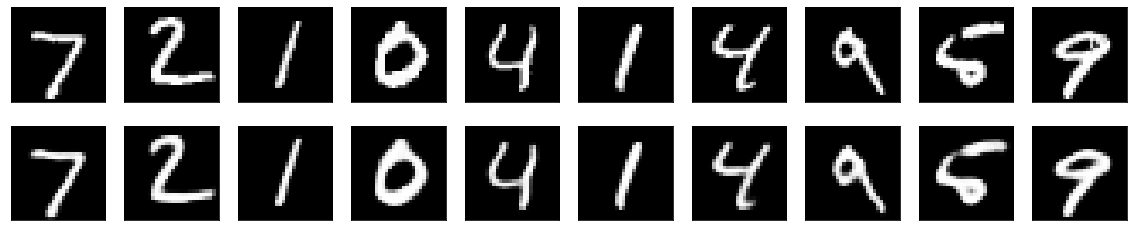

In [7]:
n = 10

imgs = x_test[:n]
encoded_imgs = c_encoder.predict(imgs, batch_size=n)
decoded_imgs = c_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

# VAE

In [4]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse


def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# network parameters
input_shape = (x_train.shape[1], x_train.shape[2], 1)
filters = 16
latent_dim = 2


inputs = Input(shape=input_shape, name='encoder_input')

x = inputs

for i in range(2):
    x = Conv2D(filters=filters,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)
    filters *= 2

shape = K.int_shape(x)

x = Flatten()(x)

# x = Dense(32, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    filters //= 2
    x = Conv2DTranspose(filters=filters,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

outputs = Conv2DTranspose(filters=1,
                          kernel_size=3,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

outputs = decoder(encoder(inputs)[2])

vae = Model(inputs, outputs, name='vae')

reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
# reconstruction_loss *= x_train.shape[1]*x_train.shape[2]

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + 1e-3*kl_loss)
vae.add_loss(vae_loss)
vae.add_metric(reconstruction_loss, 'rec_loss')
vae.add_metric(kl_loss, 'kl_loss')

vae.compile(optimizer=keras.optimizers.Adam(lr=0.01))

vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 16)   160         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 32)     4640        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1568)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [5]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [6]:
vae.fit(
    x_train.reshape(-1,28,28,1),
    x_train.reshape(-1,28,28,1),
    epochs=10,
    batch_size=128,
    validation_data=(x_test.reshape(-1,28,28,1), x_test.reshape(-1,28,28,1)),
#     callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=30, restore_best_weights=True)]
)

Epoch 1/10
469/469 [==============================] - 35s 15ms/step - loss: 0.0728 - rec_loss: 0.0706 - kl_loss: 2.1325 - val_loss: 0.0586 - val_rec_loss: 0.0558 - val_kl_loss: 2.8125
Epoch 2/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0562 - rec_loss: 0.0530 - kl_loss: 3.2158 - val_loss: 0.0547 - val_rec_loss: 0.0512 - val_kl_loss: 3.5449
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0534 - rec_loss: 0.0497 - kl_loss: 3.6773 - val_loss: 0.0527 - val_rec_loss: 0.0486 - val_kl_loss: 4.0152
Epoch 4/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0519 - rec_loss: 0.0480 - kl_loss: 3.9553 - val_loss: 0.0515 - val_rec_loss: 0.0476 - val_kl_loss: 3.9194
Epoch 5/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0511 - rec_loss: 0.0470 - kl_loss: 4.0888 - val_loss: 0.0508 - val_rec_loss: 0.0466 - val_kl_loss: 4.2362
Epoch 6/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0506 - 

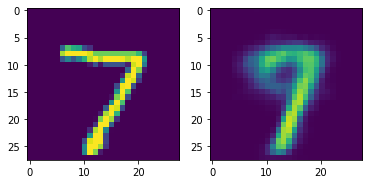

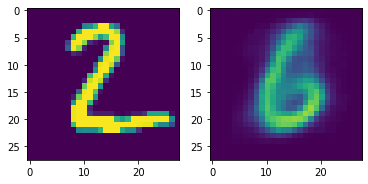

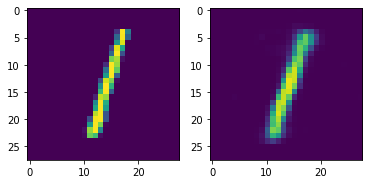

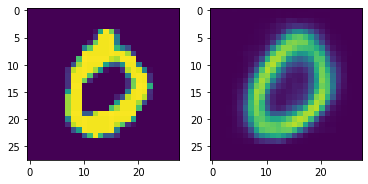

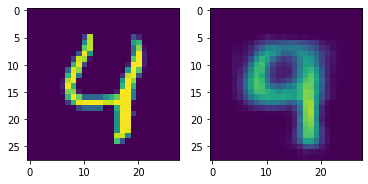

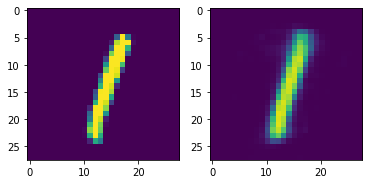

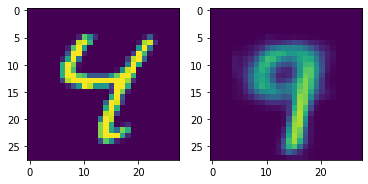

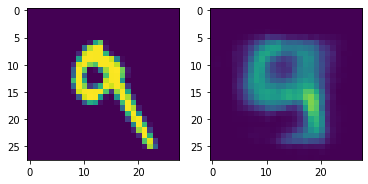

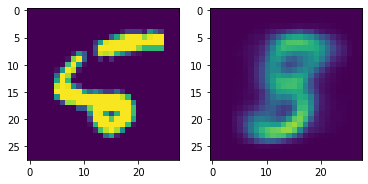

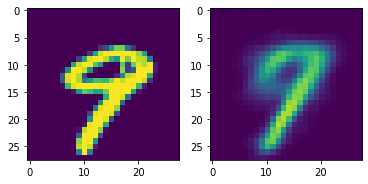

In [8]:
test_rec = vae.predict(x_test)

for i in range(10):
    fig, ax = plt.subplots(1, 2)
    
    ax[0].imshow(x_test[i].reshape((28,28)), vmin=0, vmax=1)
    # plt.show()
    # plt.figure(figsize=(1,1))
    ax[1].imshow(test_rec[i].reshape((28,28)), vmin=0, vmax=1)
    # plt.show()